<a href="https://colab.research.google.com/github/kmuhan/kmuhandeeplearning/blob/main/iris_classification_adagrad%2Bdropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch: 0/1000 Error_train : 1.0997733534725553 Error_test: 1.0994450289411524
Epoch: 100/1000 Error_train : 0.23206961502147108 Error_test: 0.22617256000941835
Epoch: 200/1000 Error_train : 0.12128737676295015 Error_test: 0.13012431956177523
Epoch: 300/1000 Error_train : 0.08215024398736591 Error_test: 0.1030721694153319
Epoch: 400/1000 Error_train : 0.062356204195165195 Error_test: 0.09250946031594438
Epoch: 500/1000 Error_train : 0.05048632168924921 Error_test: 0.08754305393304457
Epoch: 600/1000 Error_train : 0.04168548155081722 Error_test: 0.08495928052886119
Epoch: 700/1000 Error_train : 0.03571797092393285 Error_test: 0.08183658995745657
Epoch: 800/1000 Error_train : 0.031566709747853805 Error_test: 0.08236973098790097
Epoch: 900/1000 Error_train : 0.02838488592774837 Error_test: 0.08157392746368941


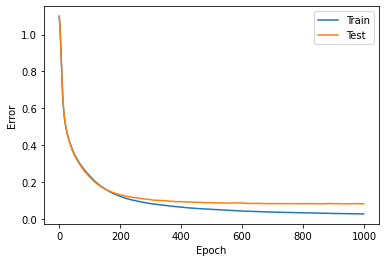

Accuracy Train:  100.0% Accuracy Test:  97.33333333333334%


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

iris_data = datasets.load_iris()
input_data = iris_data.data
correct = iris_data.target
n_data = len(correct)

ave_input = np.average(input_data, axis=0)
std_input = np.std(input_data, axis=0)
input_data = (input_data - ave_input) / std_input

correct_data = np.zeros((n_data, 3)) # 150 X 3 짜리 행렬
for i in range(n_data):
  correct_data[i, correct[i]] = 1.0

index = np.arange(n_data)
index_train = index[index%2 == 0]
index_test = index[index%2 != 0]

input_train = input_data[index_train, :]
correct_train = correct_data[index_train, :]
input_test = input_data[index_test, :]
correct_test = correct_data[index_test, :]

n_train = len(input_train)
n_test = len(input_test)

n_in = 4
n_mid = 25
n_out = 3

wb_width = 0.1
eta = 0.01
epoch = 1000
batch_size = 8
interval = 100

class BaseLayer:
  def __init__(self, n_upper, n):
    self.w = wb_width * np.random.randn(n_upper, n)
    self.b = wb_width * np.random.randn(n)

    self.h_w = np.zeros((n_upper, n)) + 1e-8
    self.h_b = np.zeros(n) + 1e-8

  def update(self, eta):
    self.h_w += self.grad_w * self.grad_w
    self.w -= (eta / np.sqrt(self.h_w)) * self.grad_w

    self.h_b += self.grad_b * self.grad_b
    self.b -= (eta / np.sqrt(self.h_b)) * self.grad_b

# update (가중치 및 편향 수정 방식)이 SGD(확률적 경사 하강법) w -= eta * aE/aw  
# class BaseLayer:
#   def __init__(self, n_upper, n):
#     self.w = wb_width * np.random.randn(n_upper, n)
#     self.b = wb_width * np.random.randn(n)

#   def update(self, eta):
#     self.w -= eta * self.grad_w
#     self.b -= eta * self.grad_b

class MiddleLayer(BaseLayer):
  def forward(self, x):
    self.x = x
    self.u = np.dot(x, self.w) + self.b
    self.y = np.where(self.u <= 0, 0, self.u)
  
  def backward(self, grad_y):
    delta = grad_y * np.where(self.u <= 0, 0, 1)

    self.grad_w = np.dot(self.x.T, delta)
    self.grad_b = np.sum(delta, axis=0)

    self.grad_x = np.dot(delta, self.w.T)

class OutputLayer(BaseLayer):
  def forward(self, x):
    self.x = x
    u = np.dot(x, self.w) + self.b
    self.y = np.exp(u)/np.sum(np.exp(u), axis=1, keepdims=True)
  
  def backward(self, t):
    delta = self.y - t

    self.grad_w = np.dot(self.x.T, delta)
    self.grad_b = np.sum(delta, axis=0)

    self.grad_x = np.dot(delta, self.w.T)

#드롭아웃 클래스 구현
class Dropout:
  def __init__(self, dropout_ratio):
    self.dropout_ratio = dropout_ratio
  
  def forward(self, x, is_train):
    if is_train:
      rand = np.random.rand(*x.shape)
      self.dropout = np.where(rand > self.dropout_ratio, 1, 0)
      self.y = x * self.dropout_ratio
    else:
      self.y = (1 - self.dropout_ratio) * x
    
  def backward(self, grad_y):
    self.grad_x = grad_y * self.dropout

middle_layer_1 = MiddleLayer(n_in, n_mid)
dropout_1 = Dropout(0.5)
middle_layer_2 = MiddleLayer(n_mid, n_mid)
dropout_2 = Dropout(0.5)
output_layer = OutputLayer(n_mid, n_out)

def forward_propagation(x, is_train):
  middle_layer_1.forward(x)
  dropout_1.forward(middle_layer_1.y, is_train)
  middle_layer_2.forward(dropout_1.y)
  dropout_2.forward(middle_layer_2.y, is_train)
  output_layer.forward(dropout_2.y)

def back_propagation(t):
  output_layer.backward(t)
  dropout_2.backward(output_layer.grad_x)
  middle_layer_2.backward(dropout_2.grad_x)
  dropout_1.backward(middle_layer_2.grad_x)
  middle_layer_1.backward(dropout_1.grad_x)

def update_wb():
  middle_layer_1.update(eta)
  middle_layer_2.update(eta)
  output_layer.update(eta)

def get_error(t, batch_size):
  return -np.sum(t * np.log(output_layer.y + 1e-7)) / batch_size

train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

#미니 배치법 구현
n_batch = n_train // batch_size
for i in range(epoch):

  forward_propagation(input_train, True)
  error_train = get_error(correct_train, n_train)
  forward_propagation(input_test, False)
  error_test = get_error(correct_test, n_test)

  test_error_x.append(i)
  test_error_y.append(error_test)
  train_error_x.append(i)
  train_error_y.append(error_train)

  if i%interval == 0:
    print("Epoch: " + str(i) + "/" + str(epoch),
          "Error_train : " + str(error_train),
          "Error_test: " + str(error_test))

  index_random = np.arange(n_train)
  np.random.shuffle(index_random)

  for j in range(n_batch):
    mb_index = index_random[j*batch_size : (j+1)*batch_size]
    x = input_train[mb_index, :]
    t = correct_train[mb_index, :]

    forward_propagation(x, True)
    back_propagation(t)

    update_wb()

plt.plot(train_error_x, train_error_y, label="Train")
plt.plot(test_error_x, test_error_y, label="Test")
plt.legend()

plt.xlabel("Epoch")
plt.ylabel("Error")

plt.show()

forward_propagation(input_train, True)
count_train = np.sum(np.argmax(output_layer.y, axis=1) == np.argmax(correct_train, axis=1))

forward_propagation(input_test, False)
count_test = np.sum(np.argmax(output_layer.y, axis=1) == np.argmax(correct_test, axis=1))

print("Accuracy Train: ", str(count_train/n_train*100) + "%",
      "Accuracy Test: ", str(count_test/n_test*100) + "%")


In [29]:
#iris1, 2, 3, 4을 이용하여 붓꽃 분류 인덱스 0, 1, 2는 각각 Setosa, Versicolor, Versinica
samples = np.array([[5.0, 3.5, 1.0, 0.5],
                    [5.5, 2.5, 4.0, 1.0],
                    [7.0, 3.0, 6.0, 2.0],
                    [6.6, 2.5, 1.5, 0.2]])

ave_input = np.average(samples, axis=0)
std_input = np.std(samples, axis=0)
samples = (samples - ave_input) / std_input

forward_propagation(samples, False)
print(output_layer.y)
for i in output_layer.y:
  print(np.argmax(i))

[[9.99978900e-01 2.10900724e-05 9.94220749e-09]
 [7.09602062e-04 9.76554967e-01 2.27354308e-02]
 [1.27688974e-08 8.29411030e-05 9.99917046e-01]
 [1.73844508e-01 8.26119512e-01 3.59793869e-05]]
0
1
2
1
